### Data Description
Pulse Transit Time PPG Dataset

(https://www.physionet.org/content/pulse-transit-time-ppg/1.1.0/#files)

In [132]:
import pandas as pd

ppg = pd.read_csv('./dataset/s9_sit.csv')
ppg

,time,ecg,peaks,pleth_1,pleth_2,pleth_3,pleth_4,pleth_5,pleth_6,lc_1,lc_2,temp_1,temp_2,temp_3,a_x,a_y,a_z,g_x,g_y,g_z
0,2021-01-01 11:53:53.793086,30259,0,67562,81029,4548,72704,100328,4386,6490394,6484197,28.38,31.25,30.270075,5.387827,2.786394,-7.666026,-0.031880,-0.003963,-0.008745
1,2021-01-01 11:53:53.795086,29614,0,67562,81029,4548,72704,100328,4386,6488845,6484192,28.38,31.25,30.264084,5.392017,2.787591,-7.667822,-0.030016,-0.004495,-0.008478
2,2021-01-01 11:53:53.797086,29126,0,67572,81036,4544,72701,100333,4390,6488845,6484192,28.38,31.25,30.264084,5.377651,2.780408,-7.661237,-0.027486,-0.004629,-0.008079
3,2021-01-01 11:53:53.799086,28984,0,67580,81030,4546,72714,100339,4386,6488845,6484192,28.38,31.25,30.261089,5.365679,2.782204,-7.654054,-0.025754,-0.004629,-0.007813
4,2021-01-01 11:53:53.801086,29217,0,67576,81015,4547,72715,100331,4392,6488845,6484192,28.38,31.25,30.261089,5.360292,2.779211,-7.652857,-0.023224,-0.004762,-0.006880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243412,2021-01-01 12:02:00.617088,29653,0,67477,80152,4101,73240,99936,4274,6558846,6530600,28.50,31.38,30.434811,5.302828,2.111195,-7.917430,0.012196,0.003095,0.016955
243413,2021-01-01 12:02:00.619088,29493,0,67474,80158,4112,73234,99927,4279,6558846,6530600,28.50,31.38,30.443794,5.308814,2.109998,-7.909050,0.012329,0.002695,0.017088
243414,2021-01-01 12:02:00.621088,29494,0,67478,80155,4108,73230,99944,4277,6560521,6531056,28.50,31.38,30.449787,5.304026,2.106406,-7.897677,0.012995,0.003095,0.017222
243415,2021-01-01 12:02:00.623088,29588,0,67472,80159,4107,73237,99948,4283,6560521,6531056,28.50,31.38,30.452782,5.305821,2.102815,-7.894085,0.013927,0.003627,0.017222


데이터 일부를 취해 heartpy 분석이 가능한지 테스트

In [133]:
import heartpy as hp
import matplotlib.pyplot as plt

sample_rate = 500

data = (ppg.iloc[0:12500, [1]]).to_numpy().flatten()
data

array([30259, 29614, 29126, ..., 31832, 31732, 31453])

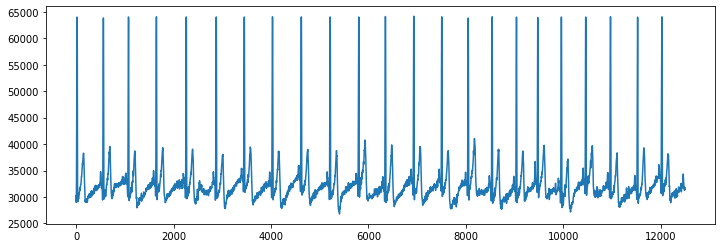

In [134]:
plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()

In [135]:
import matplotlib.pyplot as plt
import numpy as np

bpm: 54.940263
ibi: 1092.095238
sdnn: 95.249999
sdsd: 41.557069
rmssd: 71.269909
pnn20: 0.650000
pnn50: 0.550000
hr_mad: 74.000000
sd1: 50.377525
sd2: 125.906692
s: 19926.705860
sd1/sd2: 0.400118
breathingrate: 0.174414


/Users/hoho/hoho_dir/Development/github/Multi-Modality-Person-Recognition/venv/lib/python3.8/site-packages/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 864x288 with 0 Axes>

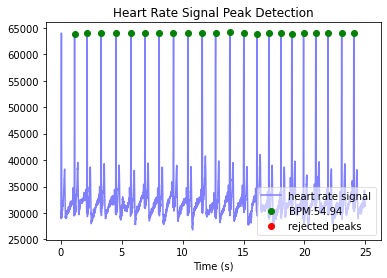

In [136]:
wd, m = hp.process(data, sample_rate)

plt.figure(figsize=(12, 4))
hp.plotter(wd, m)

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

# 데이터 전처리  
파형 특성을 담은 dataframe 만들기

In [137]:
feature_df = pd.DataFrame(columns=['subject', 'bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate'])
feature_df

,subject,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate


각 피실험자의 데이터를 분할해 heartpy로 분석하고 dataframe에 파형의 특성들을 담기  
해당 과정을 반복

In [138]:
for subject_num in range(10):
    ppg = pd.read_csv('./dataset/s' + str(subject_num+1) + '_sit.csv')
    for i in range(15): # 25초 * 15 == 375초
        start_idx = i * 12500
        data = (ppg.iloc[start_idx:start_idx+12500, [1]]).to_numpy().flatten()
        new_features_list = []

        wd, m = hp.process(data, sample_rate)

        new_features_list.append(subject_num)
        for measure in m.keys():
            print('%s: %f' %(measure, m[measure]))
            new_features_list.append(m[measure])
        
        feature_df.loc[len(feature_df)] = new_features_list

feature_df.to_csv('./dataset/processed/feature_data.csv', encoding='utf-8', mode='w', index=False)
feature_df

bpm: 75.144026
ibi: 798.466667
sdnn: 37.114897
sdsd: 18.008586
rmssd: 32.483418
pnn20: 0.586207
pnn50: 0.137931
hr_mad: 28.000000
sd1: 22.969038
sd2: 47.987761
s: 3462.766133
sd1/sd2: 0.478644
breathingrate: 0.250480
bpm: 73.380567
ibi: 817.655172
sdnn: 32.661562
sdsd: 13.840749
rmssd: 29.391447
pnn20: 0.607143
pnn50: 0.035714
hr_mad: 22.000000
sd1: 20.744498
sd2: 41.612247
s: 2711.901810
sd1/sd2: 0.498519
breathingrate: 0.126518
bpm: 74.862752
ibi: 801.466667
sdnn: 22.773864
sdsd: 12.268886
rmssd: 24.769280
pnn20: 0.482759
pnn50: 0.034483
hr_mad: 16.000000
sd1: 17.504747
sd2: 27.446890
s: 1509.380895
sd1/sd2: 0.637768
breathingrate: 0.166362
bpm: 77.467722
ibi: 774.516129
sdnn: 44.623060
sdsd: 15.566916
rmssd: 27.717624
pnn20: 0.533333
pnn50: 0.066667
hr_mad: 32.000000
sd1: 19.571862
sd2: 59.297442
s: 3646.011016
sd1/sd2: 0.330062
breathingrate: 0.208247
bpm: 72.337241
ibi: 829.448276
sdnn: 36.213530
sdsd: 17.560827
rmssd: 31.552677
pnn20: 0.571429
pnn50: 0.035714
hr_mad: 28.000000
sd

/Users/hoho/hoho_dir/Development/github/Multi-Modality-Person-Recognition/venv/lib/python3.8/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/hoho/hoho_dir/Development/github/Multi-Modality-Person-Recognition/venv/lib/python3.8/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


bpm: 54.940263
ibi: 1092.095238
sdnn: 95.249999
sdsd: 41.557069
rmssd: 71.269909
pnn20: 0.650000
pnn50: 0.550000
hr_mad: 74.000000
sd1: 50.377525
sd2: 125.906692
s: 19926.705860
sd1/sd2: 0.400118
breathingrate: 0.174414
bpm: 56.862238
ibi: 1055.181818
sdnn: 57.725555
sdsd: 25.690289
rmssd: 67.023805
pnn20: 0.952381
pnn50: 0.619048
hr_mad: 50.000000
sd1: 47.253262
sd2: 66.762516
s: 9910.928904
sd1/sd2: 0.707781
breathingrate: 0.215387
bpm: 61.901618
ibi: 969.280000
sdnn: 138.107066
sdsd: 71.911549
rmssd: 106.643487
pnn20: 0.833333
pnn50: 0.541667
hr_mad: 92.000000
sd1: 75.380125
sd2: 181.392061
s: 42956.115342
sd1/sd2: 0.415565
breathingrate: 0.082535
bpm: 64.628387
ibi: 928.384615
sdnn: 117.464259
sdsd: 33.891686
rmssd: 49.852583
pnn20: 0.600000
pnn50: 0.320000
hr_mad: 83.000000
sd1: 34.336872
sd2: 159.720756
s: 17229.471823
sd1/sd2: 0.214981
breathingrate: 0.248571
bpm: 72.397437
ibi: 828.758621
sdnn: 72.835031
sdsd: 39.905692
rmssd: 59.772187
pnn20: 0.642857
pnn50: 0.285714
hr_mad: 5

/Users/hoho/hoho_dir/Development/github/Multi-Modality-Person-Recognition/venv/lib/python3.8/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


bpm: 72.766812
ibi: 824.551724
sdnn: 38.402215
sdsd: 16.427174
rmssd: 30.815117
pnn20: 0.571429
pnn50: 0.035714
hr_mad: 28.000000
sd1: 21.733251
sd2: 49.424520
s: 3374.558959
sd1/sd2: 0.439726
breathingrate: 0.292740
bpm: 81.461368
ibi: 736.545455
sdnn: 43.560540
sdsd: 8.245264
rmssd: 15.500000
pnn20: 0.187500
pnn50: 0.000000
hr_mad: 30.000000
sd1: 10.564904
sd2: 59.339068
s: 1969.500664
sd1/sd2: 0.178043
breathingrate: 0.123426
bpm: 86.483815
ibi: 693.771429
sdnn: 26.450045
sdsd: 9.514331
rmssd: 15.826263
pnn20: 0.176471
pnn50: 0.000000
hr_mad: 16.000000
sd1: 11.184595
sd2: 35.594433
s: 1250.697262
sd1/sd2: 0.314223
breathingrate: 0.164731
bpm: 75.115096
ibi: 798.774194
sdnn: 46.319166
sdsd: 15.728389
rmssd: 27.425049
pnn20: 0.533333
pnn50: 0.033333
hr_mad: 36.000000
sd1: 18.933157
sd2: 59.185227
s: 3520.353160
sd1/sd2: 0.319897
breathingrate: 0.121153
bpm: 67.799448
ibi: 884.962963
sdnn: 39.561936
sdsd: 16.488296
rmssd: 32.031235
pnn20: 0.692308
pnn50: 0.115385
hr_mad: 16.000000
sd1:

/Users/hoho/hoho_dir/Development/github/Multi-Modality-Person-Recognition/venv/lib/python3.8/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


,subject,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
0,0.0,75.144026,798.466667,37.114897,18.008586,32.483418,0.586207,0.137931,28.0,22.969038,47.987761,3462.766133,0.478644,0.250480
1,0.0,73.380567,817.655172,32.661562,13.840749,29.391447,0.607143,0.035714,22.0,20.744498,41.612247,2711.901810,0.498519,0.126518
2,0.0,74.862752,801.466667,22.773864,12.268886,24.769280,0.482759,0.034483,16.0,17.504747,27.446890,1509.380895,0.637768,0.166362
3,0.0,77.467722,774.516129,44.623060,15.566916,27.717624,0.533333,0.066667,32.0,19.571862,59.297442,3646.011016,0.330062,0.208247
4,0.0,72.337241,829.448276,36.213530,17.560827,31.552677,0.571429,0.035714,28.0,22.275352,46.481152,3252.754871,0.479234,0.124719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9.0,76.123435,788.193548,46.128446,16.538709,29.919893,0.600000,0.066667,32.0,21.139536,62.538877,4153.320148,0.338022,0.122780
146,9.0,74.931313,800.733333,28.726217,14.579317,22.264863,0.344828,0.034483,20.0,15.728826,36.226596,1790.085172,0.434179,0.083257
147,9.0,73.698002,814.133333,27.966329,14.901021,27.782406,0.517241,0.034483,22.0,19.604169,31.491501,1939.508376,0.622523,0.122830
148,9.0,78.520770,764.129032,43.087115,17.913868,27.148972,0.333333,0.100000,28.0,18.973432,56.326824,3357.461383,0.336845,0.126646


In [139]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

feature_df = pd.read_csv('./dataset/processed/feature_data.csv')

# features
train_columns = ['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate']

# (y value type) float to int
feature_df['subject'] = feature_df['subject'].astype(int)

# train / test 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(feature_df[train_columns], feature_df['subject'],
                                                    test_size = 0.1, random_state = 32)

# normalize y value
le = LabelEncoder()
y_train = le.fit_transform(y_train)

X_train

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
113,128.556736,466.720000,163.959878,103.871373,188.194934,0.866667,0.733333,198.0,126.898034,198.931457,79306.398910,0.637898,0.171409
66,74.183976,808.800000,29.228297,14.800778,24.384845,0.379310,0.068966,20.0,17.234343,38.045533,2059.910171,0.452993,0.247280
123,64.628387,928.384615,117.464259,33.891686,49.852583,0.600000,0.320000,83.0,34.336872,159.720756,17229.471823,0.214981,0.248571
69,78.117985,768.068966,45.167833,13.813851,25.007691,0.500000,0.000000,22.0,17.067998,52.180870,2797.974686,0.327093,0.134686
10,70.351759,852.857143,61.086423,13.162277,27.632509,0.518519,0.000000,31.0,19.084535,82.403437,4940.566902,0.231599,0.125628
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,77.248941,776.709677,46.438439,21.094602,34.368590,0.500000,0.166667,34.0,24.300023,61.876741,4723.718279,0.392717,0.124595
124,72.397437,828.758621,72.835031,39.905692,59.772187,0.642857,0.285714,56.0,42.003492,92.647827,12225.609290,0.453367,0.166431
54,83.354382,719.818182,25.117246,12.888797,23.740788,0.406250,0.000000,16.0,16.770452,31.557456,1662.633855,0.531426,0.168393
133,71.900826,834.482759,43.294199,18.308579,32.386064,0.535714,0.071429,26.0,22.760734,52.075789,3723.676933,0.437069,0.247934


In [152]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=300,
                      learning_rate=0.1, 
                      max_depth=3, 
                      random_state=32, 
                      objective='multi:softprob')
model.fit(X_train, y_train) # 모델 학습

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=32, reg_alpha=0, ...)

In [153]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

accuracy_score(y_pred, y_test)

0.6666666666666666

feature의 중요도를 평가

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

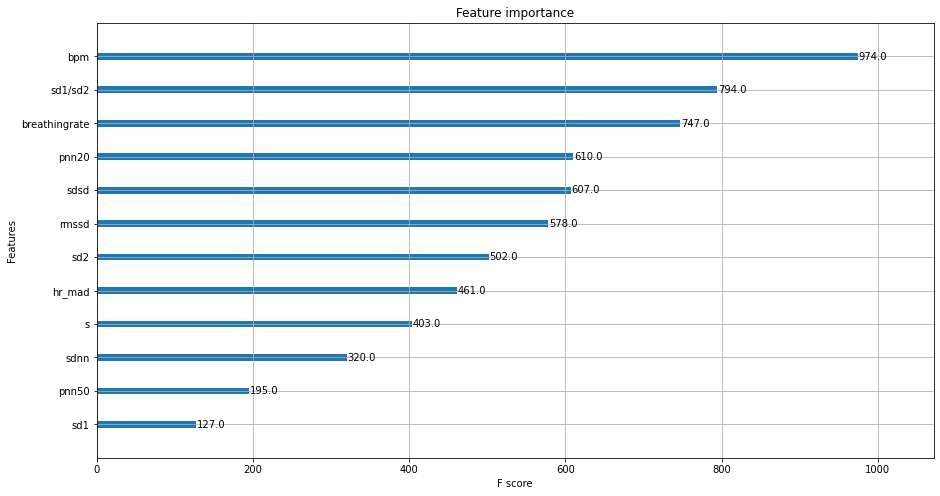

In [151]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(15, 8))
plot_importance(model, ax=ax)

plot_tree 시각화

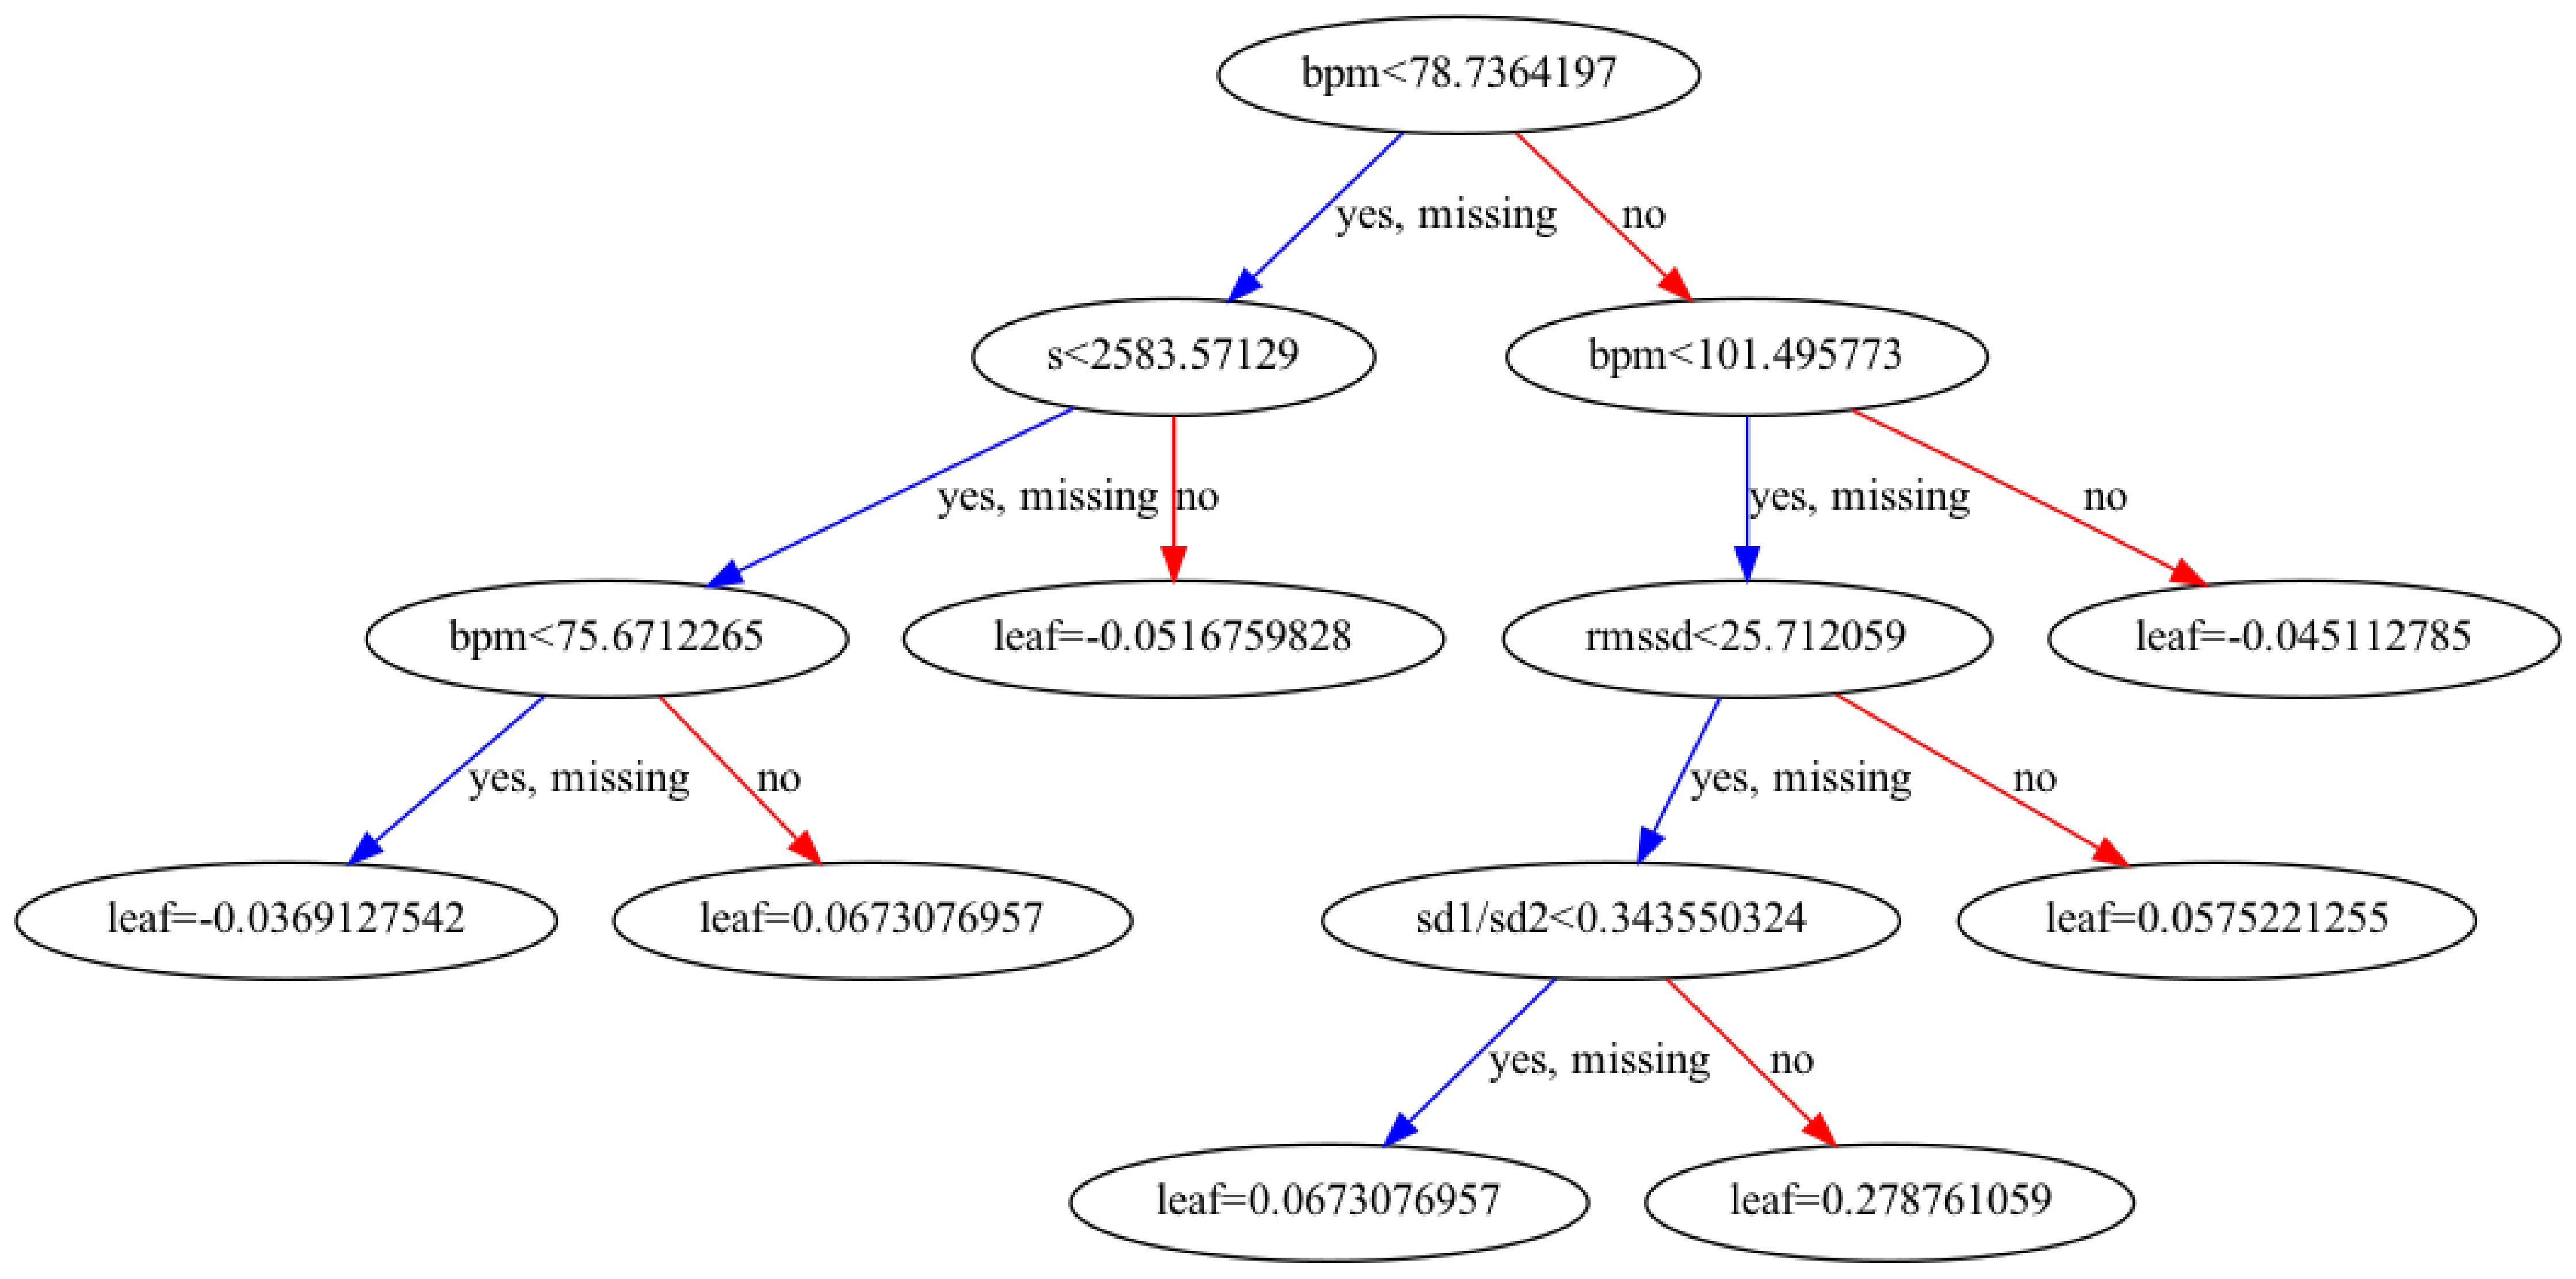

In [156]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 80, 80
plot_tree(model, num_trees=3)
plt.show()